# Clustering of gan trained on human images

In [1]:
#@title Setup (may take a few minutes)
!git clone https://github.com/warmspringwinds/segmentation_in_style.git

import os
os.chdir(f'./segmentation_in_style')

import gdown, os

url = 'https://drive.google.com/uc?id=17dXYBWVEmaqnRddiV9eh8OqVoUTSn_0W'
output_path = 'human_ada.pth'
if not os.path.exists(output_path):
    gdown.download(url, output_path, quiet=False)



Cloning into 'segmentation_in_style'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 163 (delta 70), reused 34 (delta 5), pack-reused 0
Receiving objects: 100% (163/163), 2.89 MiB | 8.18 MiB/s, done.
Resolving deltas: 100% (70/70), done.


Downloading...
From: https://drive.google.com/uc?id=17dXYBWVEmaqnRddiV9eh8OqVoUTSn_0W
To: /content/segmentation_in_style/human_ada.pth
381MB [00:03, 102MB/s]


In [104]:
import torch.nn as nn
import skimage
from skimage.color import rgb2hsv
import numpy as np

import argparse
import math
import os

import torch
from torch import optim
from tqdm import tqdm

from models.stylegan2.model import Generator
import skimage.io as io

def norm_ip(img, min, max):
    img = img.clamp(min=min, max=max)
    img = img.add(-min).div(max - min + 1e-5)
    return img


g_ema = Generator(1024, 512, 8)

g_ema.load_state_dict(torch.load('human_ada.pth')["g_ema"], strict=True)
g_ema.eval()
g_ema = g_ema.cuda()
#mean_latent = g_ema.mean_latent(4096)

mean_latent = g_ema.mean_latent(30000)

truncation = 0.5

features = None
imgs = None

with torch.no_grad():

  for i in range(1):
    sample_z = torch.randn(5, 512).cuda()
    style = g_ema.style(sample_z)
    style = mean_latent + truncation * (style - mean_latent)

    img_gen, _, out = g_ema([style], input_is_latent=True, randomize_noise=False, feature_layer_number_to_return=7)

    import skimage.io as io

    def norm_ip(img, min, max):
        img = img.clamp(min=min, max=max)
        img = img.add(-min).div(max - min + 1e-5)
        return img

    #two = norm_ip(img_gen_2[0:1, :, :, :].cpu().detach().squeeze().permute(1, 2, 0), min=-1.0, max=1.0).numpy()
    one_input = nn.functional.upsample(img_gen,
                                      size=(128, 128),
                                      mode='bilinear',
                                      align_corners=True).clamp(min=-1.0, max=1.0).detach()
    print(out.shape)
    out = nn.functional.upsample(out,
                                 size=(128, 128),
                                 mode='bilinear',
                                 align_corners=True).detach()
    if imgs is None:
      imgs = one_input.cpu()
    else:
      aditional_imgs = one_input.cpu()
      imgs = torch.cat((imgs, aditional_imgs), axis=0)

    if features is None:
      features = out.cpu()
    else:
      additional_features = out.cpu()
      features = torch.cat((features, additional_features), axis=0)



torch.Size([5, 512, 64, 64])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [15]:
features_new = features.permute(0, 2, 3, 1).reshape(-1, 512)

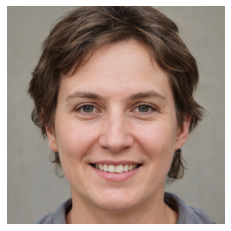

In [16]:
from matplotlib import pyplot as plt
plt.axis('off')

plt.imshow(norm_ip(img_gen[1, :, :, :].permute(1, 2, 0), min=-1.0, max=1.0).cpu().numpy())

In [17]:
import numpy as np
from skimage import io
from sklearn.cluster import KMeans

n_colors = 5

arr = features_new.detach().cpu().numpy()#dist.detach().cpu().numpy().reshape(-1, 1)
kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(arr)

In [18]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_

labels_spatial = labels.reshape(features.shape[0], features.shape[2], features.shape[3])

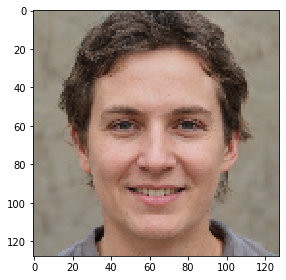

In [19]:
io.imshow( norm_ip(imgs[0, :, :, :].permute(1, 2, 0), min=-1.0, max=1.0).cpu().numpy() )

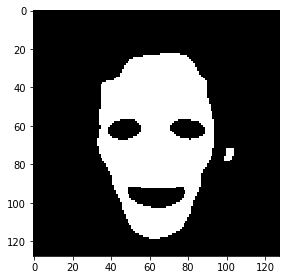

In [23]:
io.imshow(labels_spatial[0, :, :] == 3)

In [25]:
canonical_labels_spatial = (labels_spatial[0, :, :] == 3)
canonical_features_spatial = features.permute(0, 2, 3, 1)[0, :, :, :]
canonical_img_spatial = norm_ip(imgs[0, :, :, :].permute(1, 2, 0), min=-1.0, max=1.0).cpu().numpy()

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


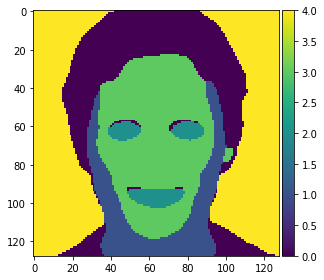

In [26]:
io.imshow(labels_spatial[0, :, :])

In [27]:
canonical_labels_spatial.shape

(128, 128)

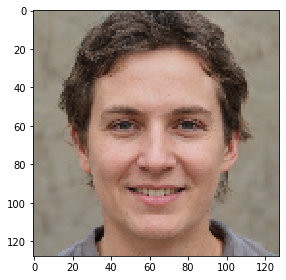

In [28]:
from matplotlib import pyplot as plt
#plt.axis('off')

io.imshow(canonical_img_spatial)

In [77]:
point_indexes = []
point_features = []

for x in range(3, 128, 8):
  for y in range(0, 128, 8):

    if canonical_labels_spatial[x, y]:
      point_indexes.append((x, y))
      point_features.append(canonical_features_spatial[x, y, :])

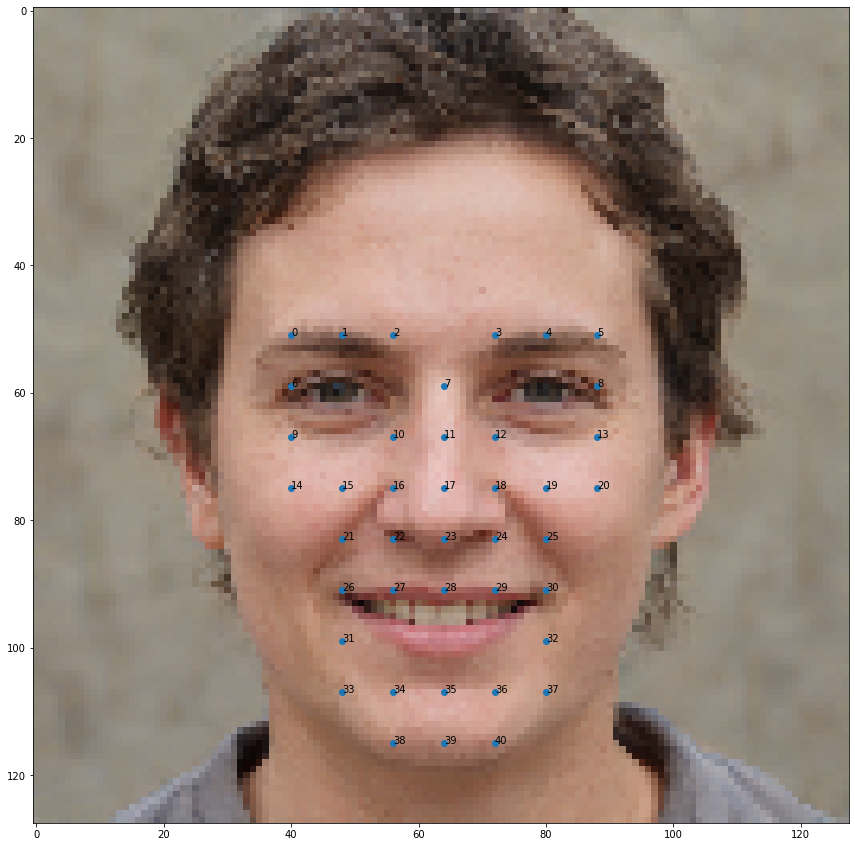

In [88]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

features_test = features.permute(0, 2, 3, 1).reshape(-1, 512)

canonical_img_spatial

fig, ax = plt.subplots()
ax.imshow(canonical_img_spatial)

x = list( map(lambda i: i[0], point_indexes) )
y = list( map(lambda i: i[1], point_indexes) )

ax.scatter(y, x)

for i in range(len(x)):
  ax.annotate(i, (y[i], x[i]))

In [79]:
del point_indexes[:16]
del point_features[:16]

In [87]:
del point_features[21]
del point_indexes[21]

In [83]:
del point_features[14]
del point_indexes[14]

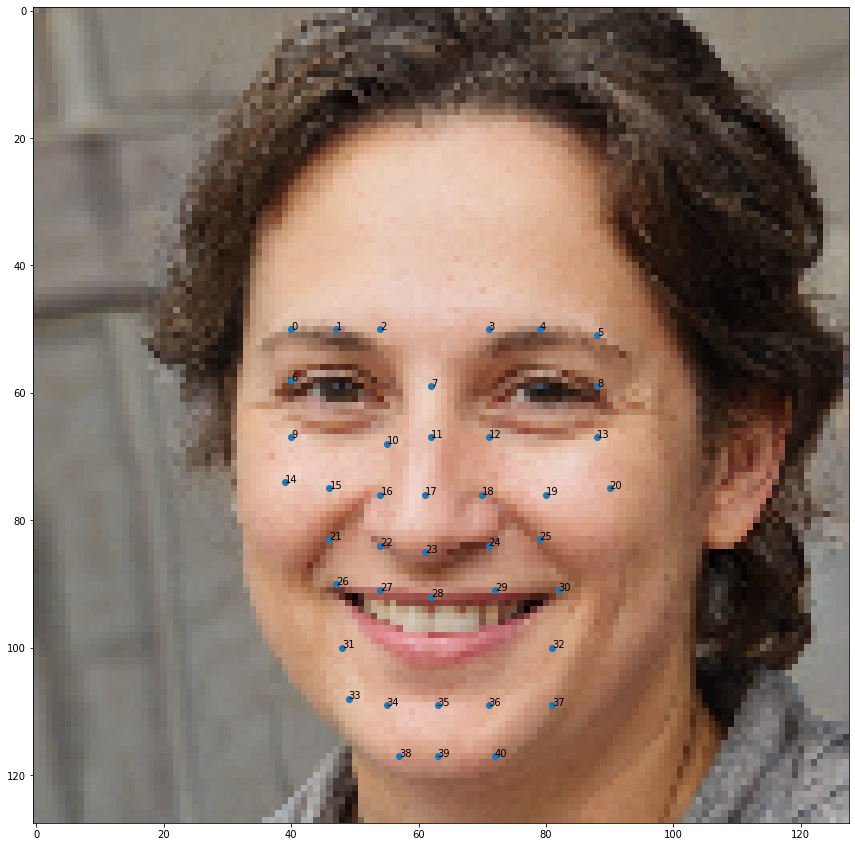

In [108]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

features_test = features.permute(0, 2, 3, 1).reshape(-1, 512)

canonical_img_spatial

fig, ax = plt.subplots()
ax.imshow(norm_ip(imgs[3, :, :, :].permute(1, 2, 0), min=-1.0, max=1.0).numpy())
#ax.scatter(z, y)

x = []
y = []
order = []

for count, _ in enumerate(point_indexes):
  head_center = point_features[count].numpy()
  head_center_torch = torch.from_numpy(head_center).unsqueeze(0)
  distances = torch.sqrt( ((features_test - head_center_torch) ** 2).sum(axis=1) )
  distances_spatial = distances.reshape(features.shape[0], features.shape[2], features.shape[3])
  distances_spatial_flatten = distances_spatial.reshape(-1, 128 * 128)
  values, indexes = distances_spatial_flatten.min(axis=1)
  indexes = indexes.numpy()

  coordinate = indexes[3]
  x_new = coordinate // 128
  y_new = coordinate % 128
  x.append(x_new)
  y.append(y_new)
  order.append(i)

ax.scatter(y, x)

for i in range(len(x)):
  ax.annotate(i, (y[i], x[i]))

In [109]:
len(point_features)

41

In [120]:
import pickle

new = torch.stack(point_features)

with open("landmakrs_uniform_41.pkl", "wb") as f:
    pickle.dump(new, f)